## Regression Algorithms
<hr>
In this notebook we implement various regression algorithms, namely the $Linear Regressor$, the $Polynomial$ and the $XGBoost$ Regressor and evaluate each one's perfokrmance through metrics such as the root mean square error (rmse) and plot that show the correlation between the predicted values and the actual ones.
<br>
<br>
As a training set we use a quasar dataset we queried from the SDSS DR16 catalogue, cross-matched with the AllWISE and the UKIDSS surveys. Their obtained photometric values act as the training features to be correlated with the dependent variable "redshift", which we will try to predict for an useen set of quasars.
<hr>

Import the respective packages:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
import lightgbm as lgb
from sklearn import metrics
import pickle
from datetime import datetime as dt
import xgboost
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor as knr 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR

### Read the CSV file

In [2]:
qso= pd.read_csv("qso_wise_ukidss_gaia.csv")

### Preparation of the data

In [3]:
qso["redshift"].describe()

count    126278.000000
mean          1.598473
std           0.846742
min           0.013172
25%           0.944167
50%           1.523757
75%           2.210103
max           7.011463
Name: redshift, dtype: float64

<hr>
The dependent variable we want to predict varies in range 0.013 - 7.011. To see how the number of quasars with different redshift values are distibuted in that range, we make a histogram of 7 bins:
<hr>

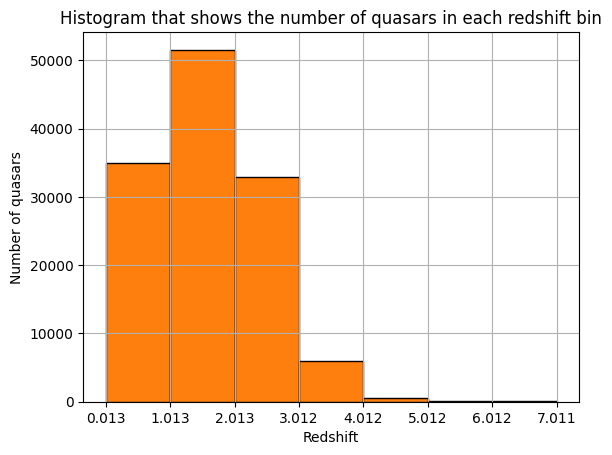

In [4]:
n, bins, patches = plt.hist(qso['redshift'], 7, density=True)
plt.hist(qso['redshift'], bins=bins, edgecolor="k")
plt.title('Histogram that shows the number of quasars in each redshift bin')
plt.xticks(bins)
plt.grid(True)
#plt.yscale('log')
plt.ylabel('Number of quasars')
plt.xlabel('Redshift')
plt.show()

<hr>
It should be noted that the y-axis of the above histogram is int logarithmic scale, to show the order of magnitude of the counts in each redshift bin. Therefore, even though the data seem to be balanced and uniformly distibuted in the redshift range, in reality the number of quasars with redshift $>5$ are 100 times less. At the same time, an inspection of the SDSS quasar catalogue reveals that the survey's pipeline in assigning redshift to distant quasars becomes les accurate the higher the redshift is. 
<br><br>

### Based on these arguments, we exclude those high redshift quasars from the training dataset, as they may entail to errors and untrustworthy training.

<hr>

Before we continue, it would be enlightening to try visualize the correlation between some of the features of the training with the dependent variable. As shown in the plot below, there is a tendency of the high redshift quasars to separate themselves with higher $g-r$ colours in the given colour colour plot. 
<hr>


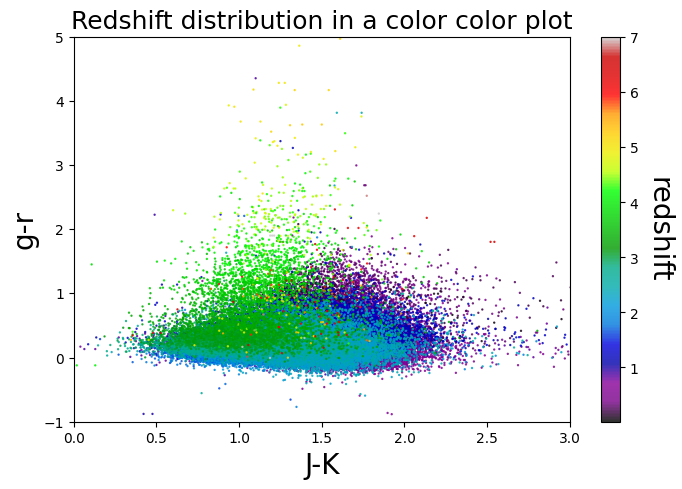

In [5]:
plt.figure(figsize = (8,5))
plt.title('Redshift distribution in a color color plot', fontsize = 18)
graph=plt.scatter(qso['j']-qso['k'], qso['g']-qso['r'],c = qso['redshift'],cmap = plt.cm.nipy_spectral, s=0.5, alpha = 0.8)
cb=plt.colorbar(graph)
cb.set_label('redshift', fontsize =20, rotation =-90, va='bottom')
plt.xlim(0,3)
plt.ylim(-1,5)
plt.xlabel('J-K', fontsize = 20)       
plt.ylabel('g-r', fontsize = 20)
#ax.tick_params(axis='x', colors='k', labelsize=15)
#ax.tick_params(axis='y', colors='k', labelsize=15)
plt.show();

In [6]:
qso

,ra,dec,u,g,r,i,z,redshift,W1mag,W2mag,...,pm,pmra,pmra_error,pmdec,pmdec_error,pm_error,pm_over_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
0,187.617241,-0.733857,19.18210,18.87277,18.29824,17.87630,17.64255,0.236228,14.649,14.031,...,0.749,0.168,0.556,-0.730,0.389,0.678570,1.103792091,19.797722,19.288520,18.200104
1,222.377045,-0.796213,18.04553,17.89540,17.49722,17.31695,17.10259,0.252452,13.553,12.681,...,0.070,-0.014,0.120,0.068,0.106,0.160112,0.437192707,17.704863,17.780537,16.944187
2,189.304366,-0.405581,19.77112,19.26213,18.49349,18.07305,17.71166,0.248751,14.236,13.513,...,0.981,0.973,1.017,0.125,0.646,1.204826,0.81422565,20.162888,19.664026,18.455063
3,189.304366,-0.405581,19.77112,19.26213,18.49349,18.07305,17.71166,0.248751,14.236,13.513,...,0.981,0.973,1.017,0.125,0.646,1.204826,0.81422565,20.162888,19.664026,18.455063
4,204.146915,-0.351780,20.15537,19.56403,18.99939,18.79128,18.37805,0.271596,14.724,13.689,...,0.357,-0.288,0.443,0.210,0.245,0.506235,0.705205909,19.275034,19.529676,18.394611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126273,203.552348,12.339086,24.63063,24.97762,21.45692,19.94777,19.62002,5.134760,16.684,15.631,...,1.992,-1.028,1.731,-1.707,1.324,2.179297,0.914056077,20.836384,20.682524,19.395786
126274,171.695714,11.145196,23.06202,21.82046,20.07817,19.65373,19.58712,4.245477,16.421,15.619,...,0.530,0.070,0.884,-0.525,0.506,1.018574,0.520335541,20.194960,21.218002,19.206768
126275,199.405327,11.092528,25.57563,23.35067,21.92303,19.67168,19.68841,4.826755,16.175,15.498,...,1.130,-0.949,2.188,-0.614,1.793,2.828815,0.399460584,NaN,NaN,19.695633
126276,205.235570,11.179159,25.60835,23.06204,21.31521,20.22416,20.07795,4.592808,16.525,15.890,...,NaN,NaN,NaN,NaN,NaN,0.000000,#DIV/0!,21.074114,21.210990,20.123650


### Cleaning the dataset
<hr>
The Nan values from the magnitudes' cells are dropped and a cut-off for quasars with redshift $>5$ is applied. We also create columns with more colour features based on magnitudes subtractions in pairs.
<hr>

In [106]:
import warnings
warnings.filterwarnings("ignore")

In [107]:
def dropnan(file):
    nan_value = float("NaN")
    file.replace("", nan_value, inplace=True)
    features = file[['u','g','r','i','z','y','j','h','k','W1mag','W2mag','W3mag','W4mag']]

    for i in features.columns:
        file.dropna(subset = [i], inplace=True)

In [108]:
qso= qso[qso["redshift"]<5]
dropnan(qso)

In [109]:
qso["ug"]= qso["u"]-qso["g"]
qso["ur"]= qso["u"]-qso["r"]
qso["ui"]= qso["u"]-qso["i"]
qso["uz"]= qso["u"]-qso["z"]
qso["gr"]= qso["g"]-qso["r"]
qso["gi"]= qso["g"]-qso["i"]
qso["gz"]= qso["g"]-qso["z"]
qso["ri"]= qso["r"]-qso["i"]
qso["rz"]= qso["r"]-qso["z"]
qso["iz"]= qso["i"]-qso["z"]
qso["W1W2"]= qso["W1mag"]-qso["W2mag"]
qso["W1W3"]= qso["W1mag"]-qso["W3mag"]
qso["W1W4"]= qso["W1mag"]-qso["W4mag"]
qso["W2W3"]= qso["W2mag"]-qso["W3mag"]
qso["W2W4"]= qso["W2mag"]-qso["W4mag"]
qso["W3W4"]= qso["W3mag"]-qso["W4mag"]
qso["YJ"]= qso["y"]-qso["j"]
qso["YH"]= qso["y"]-qso["h"]
qso["YK"]= qso["y"]-qso["k"]
qso["JH"]= qso["j"]-qso["h"]
qso["JK"]= qso["j"]-qso["k"]
qso["HK"]= qso["h"]-qso["k"]
qso["iK"]= qso["i"]-qso["k"]

### Split the training set
<hr>
This step could also be done by using the $train$_ $test$_ $split$ from the $sklearn$ library. However, we are going to train more than one models, and in the case of the polynomial regressor, the computational power required for the given number of features (36) is more than the available one. We therefore use the same training and test sets for all the models but with different number of features each time, and we later compare the predictions' results. Training set is chosen to be $80\%$ of the whole dataset.
<hr>

In [110]:
df_train  = qso.sample(frac = 0.8)
df_test = qso.drop(df_train.index)
print("Shape of new datasets - {} , {}".format(df_train.shape, df_test.shape))

Shape of new datasets - (69668, 52) , (17417, 52)


### How the regressors work:
<hr>
X has 36 dimensions/features meaning that a regression model should make a function:
<br>

## $y$ = $\beta_0 +\beta_1x_1+\beta_2x_2+...+\beta_{36}x_{36}$
<br>
Now the assumption is that there could be a linear relation between these 36 dimentions and an extra dimension with the redshift
<hr>

In [11]:
import warnings
warnings.filterwarnings("ignore")

## Initialize the regression models that will be used:

In [12]:
linear_r = LinearRegression()                                    #model for the linear regression

xgb_r = xgboost.XGBRegressor(objective ='reg:squarederror', 
        min_child_weight=1,max_depth=9, n_estimators = 200, 
        seed = 42,eval_metric="rmsle")                           # model for the XGBoost regression

poly_r = PolynomialFeatures(degree=2, include_bias=False)        #model for the polynomial regression

knn_r = knr(n_neighbors=6)                                       #model for the nearest neighbors regression

svm_r = LinearSVR()                                              #model for the support vector machine regression

<hr>
The following 2 cells define a standardised way of plotting. The $fig()$ and the $plot$_ $regression()$ functions are used in the $regression()$ def that follows to plot the feature importance and the actual vs the predicted redshifts, respectively. The $plot$_$regression()$ also includes the plotting of the linear relation $y=x$ in order to demonstrate visually the deviation of the fitted model from the ideal case scenario.
<hr>

In [13]:
def fig(title=''):
    if title=='':
        title = ' Regression model XGBoost'
    plt.figure(figsize = (14,4))
    plt.title(title);

In [14]:
def plot_regression(rmse_test,y_pred_test,y_test):
    plt.figure(figsize=(7,5))
    x=[0,1,2,3,4,5]
    y=[]
    for i in[0,1,2,3,4,5]:
        yval=x[i]
        y.append(yval)
    plt.plot(x,y,color="red")
    plt.scatter(y_pred_test,y_test,color="purple",s=2)

    plt.xlabel(f"Predicted redshift by the model",fontsize=15)
    plt.ylabel("Actual redshift",fontsize=15)
    plt.annotate(f"rmse on the test set: {rmse_test:.2f}", (0,4.8),fontsize=15,color="k") 

    plt.show();

<hr>
The $regression()$ function requires the user to enter the desirable regression model that he wants to perform the training and the predictions with, fits the model and calculates the errors on the training as well as on the test sets. It also stores the predictions in the $y$_$pred$_$list$, in order to compare all the models' predictions and estimate a collective mean redshift value for each quasar. Finally, it plots the results and prints a report for the corresponding model training (running time, rmse).
<hr>

In [15]:
y_pred_list=[]
def regression(model, x_train, y_train, x_test, y_test):
    if model==poly_r:
        x_train = model.fit_transform(x_train)
        x_test = model.fit_transform(x_test)
        model = LinearRegression()
    print('-- Fitting Model --')  
    start=dt.now()
    model.fit(x_train, y_train) 
    running_time = (dt.now()-start).seconds
    print('-- Fitting has been completed! --')    
    print('-- Running time = ', running_time, 'seconds')

    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    y_pred_list.append(y_pred_test)
    #print(f"intercept: {model.intercept_}")
    #print(f"coefficients: {model.coef_}")
    mae_train = metrics.mean_absolute_error(y_train,y_pred_train)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train,y_pred_train))

    mae_test = metrics.mean_absolute_error(y_test,y_pred_test)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test,y_pred_test))
    rmse_test = float("{:.2f}".format(rmse_test))
    print('{0:30}{1:^20}{2:^30}{3:^20}'.format('Training: mean absolute error', 'Training: rmse',
                                                  'Test: mean absolute error', 'Test: rmse'))
    print('{0:20.2e} {1:^38.2e} {2:^10.2e} {3:^38.2e}'.format(mae_train, rmse_train, mae_test, rmse_test))  
    plot_regression(rmse_test,y_pred_test,y_test)

    if model==xgb_r:
        fig()
        plot=sns.barplot(x=x_train.columns, y = model.feature_importances_)
        plot.set_xticklabels(plot.get_xticklabels(), rotation = 'vertical')


## Feature Selection 

In [16]:
# Features for the linear and the XGBoost regression:

x_train = df_train[['u', 'g', 'r', 'i', 'z', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'y','j',
               'h', 'k','ug', 'ur','ui','uz','gr', 'gi','gz', 'ri', 'rz','iz', 'YJ',
               'YH','YK', 'JH', 'JK', 'HK', 'iK','W1W2', 'W1W3', 'W1W4', 'W2W3', 'W2W4', 'W3W4']]  

x_test = df_test[['u', 'g', 'r', 'i', 'z', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'y','j',
               'h', 'k','ug', 'ur','ui','uz','gr', 'gi','gz', 'ri', 'rz','iz', 'YJ',
               'YH','YK', 'JH', 'JK', 'HK', 'iK','W1W2', 'W1W3', 'W1W4', 'W2W3', 'W2W4', 'W3W4']]  

# Features for the polynomial regression:

x_train_poly = df_train[['ug', 'YK', 'W2W3']] 

x_test_poly = df_test[['ug',  'YK', 'W2W3']] 


y_train=df_train['redshift']

y_test = df_test['redshift']

## XGBoost Regressor results

-- Fitting Model --
-- Fitting has been completed! --
-- Running time =  30 seconds
Training: mean absolute error    Training: rmse     Test: mean absolute error        Test: rmse     
            3.99e-02                5.85e-02                 1.37e-01                 2.50e-01               


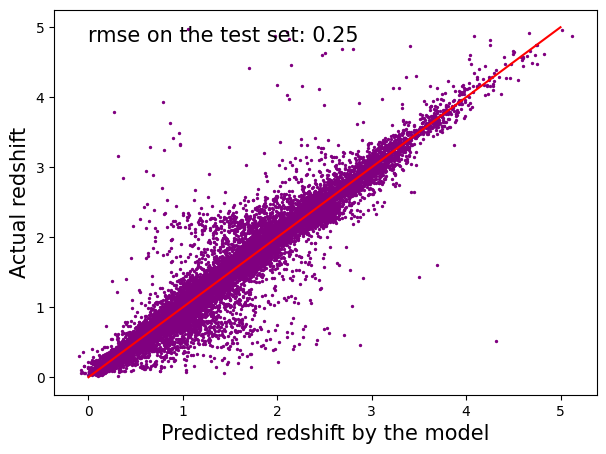

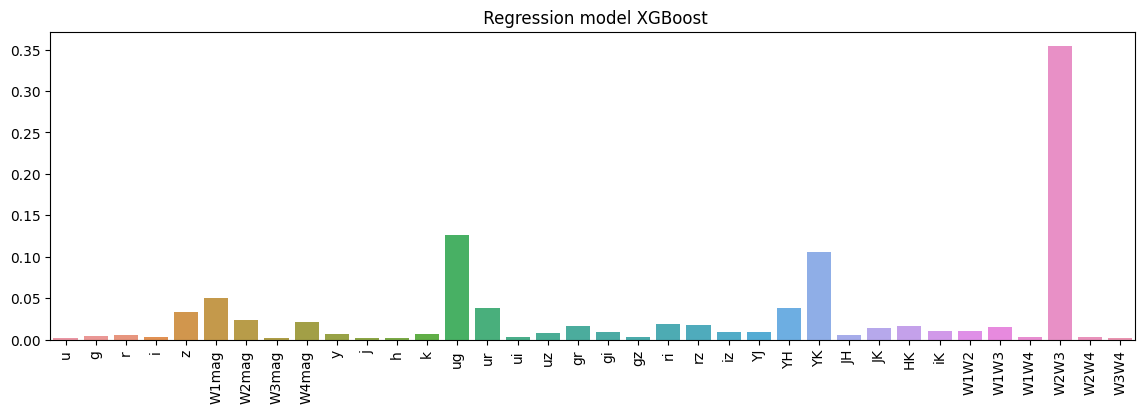

In [17]:
regression(xgb_r, x_train, y_train, x_test, y_test)

## Polynomial Regressor results

-- Fitting Model --
-- Fitting has been completed! --
-- Running time =  4 seconds
Training: mean absolute error    Training: rmse     Test: mean absolute error        Test: rmse     
            2.58e-01                3.66e-01                 2.63e-01                 4.30e-01               


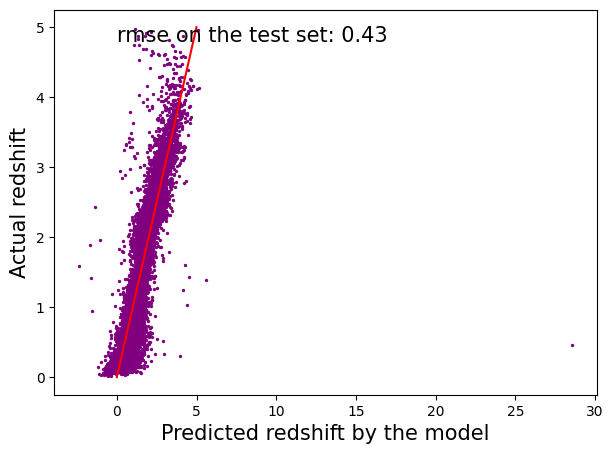

In [18]:
regression(poly_r, x_train, y_train, x_test, y_test)

## Linear Regressor results

-- Fitting Model --
-- Fitting has been completed! --
-- Running time =  0 seconds
Training: mean absolute error    Training: rmse     Test: mean absolute error        Test: rmse     
            3.22e-01                4.48e-01                 3.25e-01                 4.60e-01               


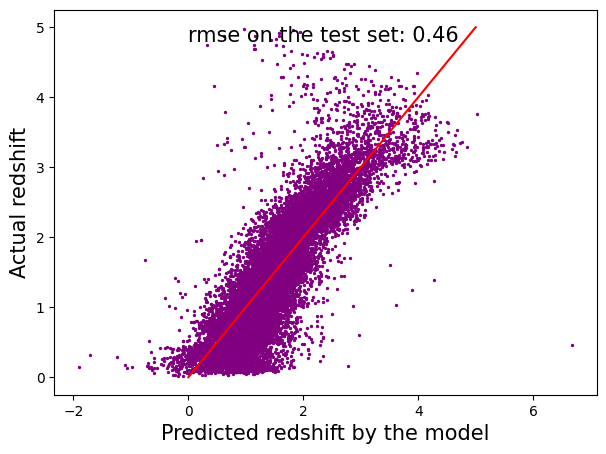

In [19]:
regression(linear_r, x_train, y_train, x_test, y_test)

## kNN regressor - Tuning the n parameter
<hr>
Tuning the number of neighbors parameter
<hr>

rmse= 0.31693180692147166 for k= 1
rmse= 0.28202336525606414 for k= 2
rmse= 0.27608796831277616 for k= 3
rmse= 0.27282284223659886 for k= 4
rmse= 0.269732554896719 for k= 5
rmse= 0.26956598255681435 for k= 6
rmse= 0.26935525892631346 for k= 7
rmse= 0.2685360808549916 for k= 8
rmse= 0.26867650438979296 for k= 9
rmse= 0.26902442559747347 for k= 10
rmse= 0.2694860706322714 for k= 11
rmse= 0.2703188536965911 for k= 12
rmse= 0.2706200727718406 for k= 13
rmse= 0.2703938695075718 for k= 14
rmse= 0.2716805311838341 for k= 15


Text(0, 0.5, 'rmse')

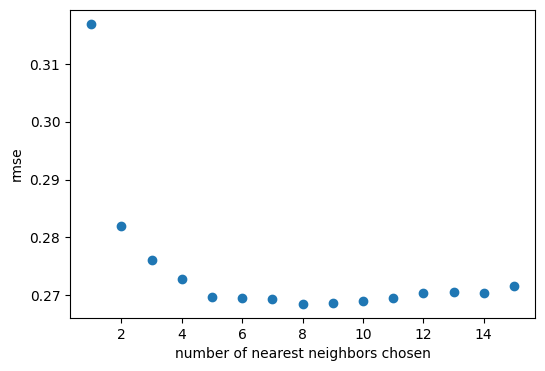

In [20]:
rmse_knn=[]
kvalue=[]
for k in range(1,16):
    model = knr(n_neighbors=k)
    model.fit(x_train,y_train)
    pred_knn = model.predict(x_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test,pred_knn))
    rmse_knn.append(rmse)
    print('rmse=', rmse, 'for k=', k)
    kvalue.append(k)   
plt.figure(figsize=(6,4))
plt.scatter(kvalue, rmse_knn) 
plt.xlabel('number of nearest neighbors chosen')
plt.ylabel('rmse')

In [21]:
a = np.argmin(rmse_knn)  # finds the index in which the rmse takes its minimum values
print('The root mean spuared error is taking its minimum value','{:.4f}'.format(rmse_knn[a]), 'for a number of nearest neighbors n=', a+1) 

The root mean spuared error is taking its minimum value 0.2685 for a number of nearest neighbors n= 8


## kNN Regressor results

-- Fitting Model --
-- Fitting has been completed! --
-- Running time =  0 seconds
Training: mean absolute error    Training: rmse     Test: mean absolute error        Test: rmse     
            1.13e-01                2.23e-01                 1.36e-01                 2.70e-01               


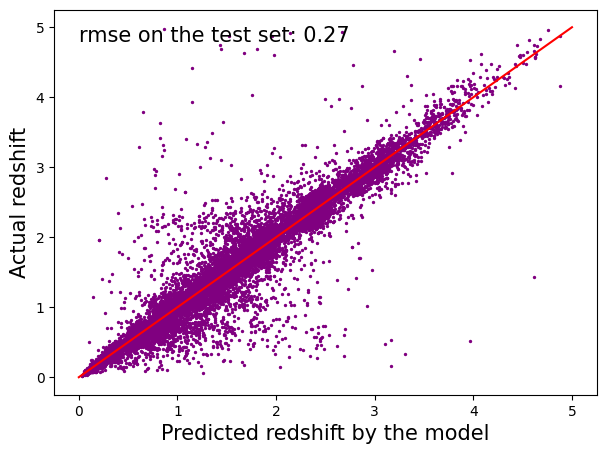

In [22]:
regression(knn_r, x_train, y_train, x_test, y_test)

## SVM Regressor results

-- Fitting Model --
-- Fitting has been completed! --
-- Running time =  46 seconds
Training: mean absolute error    Training: rmse     Test: mean absolute error        Test: rmse     
            4.18e-01                5.38e-01                 4.22e-01                 5.50e-01               


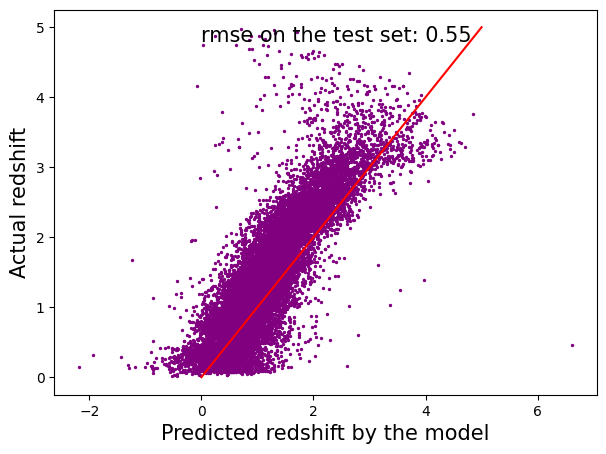

In [23]:
regression(svm_r, x_train, y_train, x_test, y_test)

<hr>

## It seems like the best models for predicting the are the XGBoost and the kNN Regressors! Let's see how the predictions relate to the actual redshift values when we combine the results from those 2 models: 
<hr>

In [24]:
y_ensemble = (y_pred_list[0]+y_pred_list[3])/2

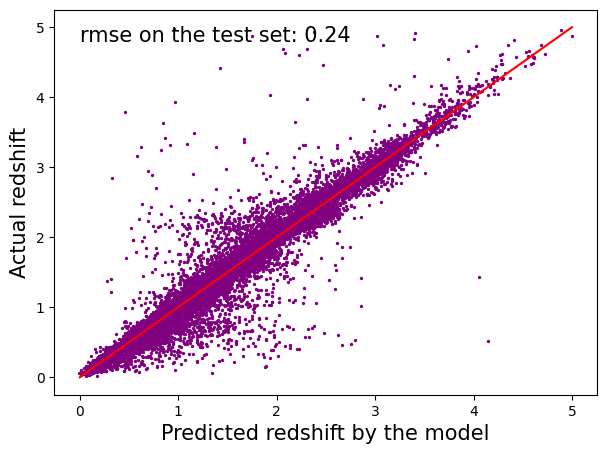

In [25]:
rmse_ensemble = np.sqrt(metrics.mean_squared_error(y_test,y_ensemble))
plot_regression(rmse_ensemble,y_ensemble,y_test)


<hr>
The rmse actually drops by 0.02 in the combined results approach
<hr>

# Making redshift predictions for gaia dataset 40 < b < 90 


<hr>
The unseen dataset that we use for redshift predictions is queried from the GAIA EDR3 survey :

<a href='https://gea.esac.esa.int/archive/'>Link to Gaia Archives</a>

The astronomical objects are found in galactic latitudes $40^ {\circ} < b < 90^ {\circ} $.

It should also be noted that those objects have not been spectroscopically observed, we therefore cannot evaluate the predictions the models make.
<hr>

In [26]:
cand9070 = pd.read_csv("9070_wise_ukidss_sdss.csv")
cand7060 = pd.read_csv("7060_wise_ukidss_sdss.csv")
cand6050 = pd.read_csv("6050_wise_ukidss_sdss.csv")
cand5040 = pd.read_csv("5040_wise_ukidss_sdss.csv")

Concatenate the different files in 1 pd dataframe:

In [72]:
cand =pd.concat([cand9070,cand7060,cand6050,cand5040],axis=0)

<hr>
Define a $rename()$ function to convert the names of the new csv file to the previous format used in the training sataset
<hr>

In [73]:
def rename():
    test = cand.drop_duplicates(subset="ra")

    names1 = ['umag','gmag','rmag','imag','zmag','yAperMag3','j_1AperMag3','hAperMag3','kAperMag3']
    names2 = ['u','g','r','i','z','y','j','h','k']
    for i, j in zip(names1,names2):
        test.rename(columns = {i:j}, inplace = True)

In [74]:
rename()

In [76]:
dropnan(test)

In [77]:
test["ug"]=   test["u"]-test["g"]
test["ur"]=   test["u"]-test["r"]
test["ui"]=   test["u"]-test["i"]
test["uz"]=   test["u"]-test["z"]
test["gr"]=   test["g"]-test["r"]
test["gi"]=   test["g"]-test["i"]
test["gz"]=   test["g"]-test["z"]
test["ri"]=   test["r"]-test["i"]
test["rz"]=   test["r"]-test["z"]
test["iz"]=   test["i"]-test["z"]
test["W1W2"]= test["W1mag"]-test["W2mag"]
test["W1W3"]= test["W1mag"]-test["W3mag"]
test["W1W4"]= test["W1mag"]-test["W4mag"]
test["W2W3"]= test["W2mag"]-test["W3mag"]
test["W2W4"]= test["W2mag"]-test["W4mag"]
test["W3W4"]= test["W3mag"]-test["W4mag"]
test["YJ"]=   test["y"]-test["j"]
test["YH"]=   test["y"]-test["h"]
test["YK"]=   test["y"]-test["k"]
test["JH"]=   test["j"]-test["h"]
test["JK"]=   test["j"]-test["k"]
test["HK"]=   test["h"]-test["k"]
test["iK"]=   test["i"]-test["k"]

In [78]:
x_test=test[['u', 'g', 'r', 'i', 'z', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'y','j',
               'h', 'k','ug', 'ur','ui','uz','gr', 'gi','gz', 'ri', 'rz','iz', 'YJ',
               'YH','YK', 'JH', 'JK', 'HK', 'iK','W1W2', 'W1W3', 'W1W4', 'W2W3', 'W2W4', 'W3W4']] 

<hr>
We now make predictions based on the xgb regressor and save them as a column of the initial test dataframe:
<hr>

In [82]:
pred_gaia_xgb = xgb_r.predict(x_test)

In [83]:
pred_test_df = pd.DataFrame(pred_gaia_xgb)

In [84]:
pred_test_df.describe()

,0
count,57199.000000
mean,1.867120
std,0.926185
min,-0.172928
25%,1.139661
50%,1.766875
75%,2.704076
max,5.011205


In [85]:
test["redshift_prediction"] = pred_gaia_xgb

Text(0.5, 0, 'Predicted redshift')

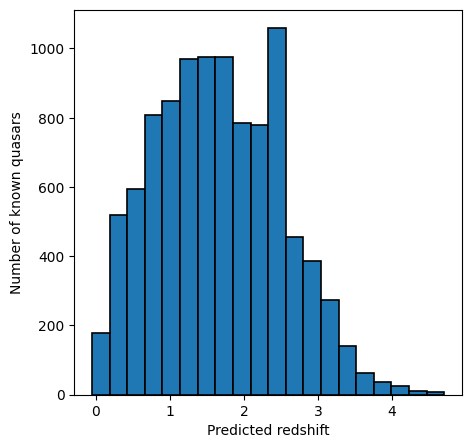

In [119]:
plt.figure(figsize = (5,5))

plt.hist(test["redshift_prediction"][test['spCl']=='QSO'], density=False, bins=20,edgecolor='black', linewidth=1.2) 
plt.ylabel('Number of known quasars', fontsize = 10)
plt.xlabel('Predicted redshift', fontsize = 10)  

<hr>
An error based on physical arguments would be the number of stars or galaxies that the model has predicted with very high redshift (higher than 4), because for some of the objects we have their spectral class ($test['spCl']$) available (by cross-matching with the SDSS). That is because the stars we measure lie in our own galaxy, and are very close to us, in cosmic scales. All the stars are therefore expected to have redshift close to zero. The galaxies on the other hand lie in our cosmic neighbourhood, and are typically characterised by small redshifts (around 0.2-1). We therefore expect from a good fitting to predict none, or at least very few galaxies/stars with high redshifts.
<hr>

In [105]:
print('The model has predicted',len(test[(test["redshift_prediction"]>1) & (test["spCl"]=="GALAXY")]),'galaxies with high redshift')
print('The model has predicted',len(test[(test["redshift_prediction"]>0.1) & (test["spCl"]=="STAR")]),'stars with high redshift, out of the total',len(test[test["spCl"]=="STAR"]), 'number of stars')
print('The model has predicted',len(test[(test["redshift_prediction"]>4) & (test["spCl"]=="QSO")]),'quasars with high redshift')

The model has predicted 42 galaxies with high redshift
The model has predicted 95 stars with high redshift, out of the total 95 number of stars
The model has predicted 43 quasars with high redshift


<hr>
As seen above, the regression algorithm has assinged high redshift values to all the stars that populate the given unseen catalogue. This is an inevitable result: we have trained the model on a training dataset that only includes quasars and no stars. In that sense, the algorithm has never learned what redshift a star actually has. On the other hand, if we plotted the quasars and the stars in a same colour-colour plot, we would see that the stars form a cluster right nect to the region where the high-redshift quasars are found. That explains why being given the colours of the sources, the regressor assigned high-redshift values to stars! 
<hr>

Let's see the situation in colour colour plots: The stellar locus is more distinguishable in the third plot, on the left side of the high-redshifted quasars:
<hr>

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
graph = plt.scatter( test['W1W2'],test['gr'], s = 0.5, c = test['redshift_prediction'],cmap = plt.cm.nipy_spectral)
plt.xlim(-1,2)
plt.ylim(-1,2.5)
plt.xlabel('W1 - W2', fontsize = 13)      
plt.ylabel('g-r', fontsize = 13)

plt.subplot(1, 3, 2)
graph = plt.scatter( test['W1W2'],test['ug'], s = 0.5, c = test['redshift_prediction'],cmap = plt.cm.nipy_spectral)
plt.xlim(-1,2)
plt.ylim(-0.5,3)
plt.xlabel('W1 - W2', fontsize = 13)      
plt.ylabel('u-g', fontsize = 13)

plt.subplot(1, 3, 3)
graph = plt.scatter( test['JK'],test['gr'], s = 0.5, c = test['redshift_prediction'],cmap = plt.cm.nipy_spectral)
x=np.linspace(0,10,10)
y=1.5*x-0.6               ##that plots a line that roughly separates the quasars from the stars in the 3rd subplot
plt.plot(x,y)
plt.xlim(-0.1,2.5)
plt.ylim(-0.5,2.8)
cb=plt.colorbar(graph)
cb.set_label('redshift', fontsize =10, rotation =-90, va='bottom')
plt.xlabel('J-K', fontsize = 13)      
plt.ylabel('g-r', fontsize = 13)

plt.show();

Text(0.5, 0, 'Predicted redshift')

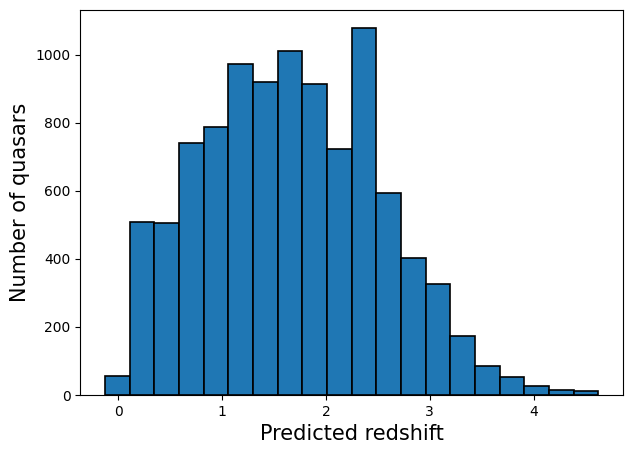